In [598]:
import pandas as pd
pd.set_option('display.max_columns', 75)

In [599]:
nbaData="NBAdata.csv"
temp=pd.read_csv(nbaData)
stats=temp.copy()
stats=stats.drop("#", axis=1)
stats=stats.drop("blank2", axis=1)
stats=stats.drop("blanl", axis=1)

stats.rename(columns={"Season Start": "Season"}, inplace=True)
stats.rename(columns={"Tm": "Team"}, inplace=True)
stats.rename(columns={"Player Name": "Name"}, inplace=True)
stats.rename(columns={"Player Salary in $": "Salary"}, inplace=True)
stats.rename(columns={"G": "GP"}, inplace=True)

#mapping numeric values onto positions
mapping = {'PG': 1, 'SG': 2, 'SF': 3, 'PF': 4, 'C':5}
stats['Pos'] = stats['Pos'].map(mapping)

In [600]:
#ratio of Games started to games played
stats["GS/GP"]=stats["GS"]/stats["GP"]

#removing last row from dataset because it's null
stats=stats[:-1]

In [601]:
#stats should be a on a per-game basis instead of totals to eliminate the effect of games played
stats["MPG"]=stats["MP"]/stats["GP"]
stats["ORPG"]=stats["ORB"]/stats["GP"]
stats["DRPG"]=stats["DRB"]/stats["GP"]
stats["RPG"]=stats["TRB"]/stats["GP"]
stats["APG"]=stats["AST"]/stats["GP"]
stats["SPG"]=stats["STL"]/stats["GP"]
stats["BPG"]=stats["BLK"]/stats["GP"]
stats["TPG"]=stats["TOV"]/stats["GP"]
stats["PFPG"]=stats["PF"]/stats["GP"]
stats["PPG"]=stats["PTS"]/stats["GP"]
stats["FGPG"]=stats["FG"]/stats["GP"]
stats["FGAPG"]=stats["FGA"]/stats["GP"]
stats["3PPG"]=stats["3P"]/stats["GP"]
stats["3PAPG"]=stats["3PA"]/stats["GP"]
stats["2PPG"]=stats["2P"]/stats["GP"]
stats["2PAPG"]=stats["2PA"]/stats["GP"]
stats["FTPG"]=stats["FT"]/stats["GP"]
stats["FTAPG"]=stats["FTA"]/stats["GP"]

#drop all total columns
drop_column = ['MP', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'FG', 'FGA', '3P', '3PA', '2P', '2PA', 'FT', 'FTA']
stats.drop(drop_column, axis=1, inplace = True)



In [602]:
#splitting stats into 3 categories for later on, when looking at which group of stats is the best predictor of salary
advanced=['% of Cap','PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']
regular=['% of Cap','ORPG', 'DRPG', 'RPG', 'APG', 'SPG', 'BPG', 'TPG', 'PFPG', 'PPG', 'FGPG', 'FGAPG', '3PPG', '3PAPG', '2PPG', '2PAPG', 'FTPG', 'FTAPG']
basic=['% of Cap','Pos', 'Age', 'MPG', 'GP']

#change salary from object to float
stats["Salary"] = stats.Salary.astype(float)

#removed stars from some players names
stats['Name'] = stats['Name'].map(lambda x: x.rstrip('*'))


In [603]:
#dataset had total stats for a player if he was on two teams in one season, but we wanted to look at data on specific teams, too, so the "TOT" value wouldn't work
stats=stats[~stats["Team"].str.contains("TOT", na=False)]

#players don't qualify if they've played in less than or equal to 15 games on a team
stats=stats[stats['GP']>15]

#if no salary is in the dataset, we can't use that row
stats=stats.dropna(subset = ['Salary'])


#if a player still had a NaN at this point, it meant they didn't take any shots that season, so give them values of 0s for the percentages columns
empty=['TS%','3PAr','FTr','TOV%','FG%','3P%','2P%','eFG%','FT%']
for i in empty:
    stats[i].fillna(0, inplace=True)



In [604]:
#teams have changed names and locations over the years, this is keeping the franchises consistent
stats["Team"].replace("CHH", "NOP", inplace=True)
stats["Team"].replace("NOH", "NOP", inplace=True)
stats["Team"].replace("NOK", "NOP", inplace=True)
stats["Team"].replace("NJN", "BRK", inplace=True)
stats["Team"].replace("WSB", "WAS", inplace=True)
stats["Team"].replace("SEA", "OKC", inplace=True)
stats["Team"].replace("VAN", "MEM", inplace=True)
stats["Team"].replace("CHA", "CHO", inplace=True)
len(stats["Team"].unique())
#now only thirty teams in the league

30

In [605]:
#salary cap for all years from 1995 to 2017
from pandas import *
my_dic = pd.read_excel('salaryCap.xlsx', index_col=0).to_dict()
cap=my_dic['Salary Cap']

In [606]:
#to normalize salaries, make them as a percentage of the salary cap in that year
stats['Cap'] = stats['Season'].map(cap)
stats['% of Cap']=(stats['Salary']/stats['Cap'])*100

[]

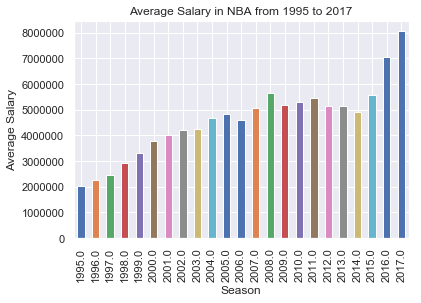

In [608]:
#DATA EXPLORATION
#Get mean of average NBA Salary from each year to show that it doesn't make sense to look at absolute salaries
sal=stats.groupby('Season')['Salary'].mean()
var=sal.plot.bar(x='Season', y='Salary')
var.set_ylabel("Average Salary")
var.set_title("Average Salary in NBA from 1995 to 2017")
var.plot()

[]

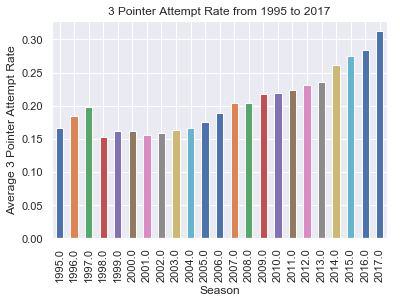

In [609]:
#Plot showing how 3 Point Attempt Rate has changed over time
threePM=stats.groupby('Season')['3PAr'].mean()
graph=threePM.plot.bar()
graph.set_ylabel('Average 3 Pointer Attempt Rate')
graph.set_title('3 Pointer Attempt Rate from 1995 to 2017')
graph.plot()

(45, 57)

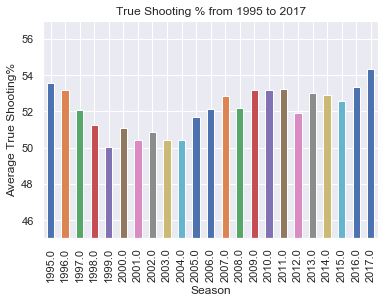

In [610]:
#More data exploration, looking at how an advanced metric, True Shooting %, has changed over time
ts=stats.groupby('Season')['TS%'].mean()
ts=ts*100
graph=ts.plot.bar()
graph.set_ylabel('Average True Shooting%')
graph.set_title('True Shooting % from 1995 to 2017')
graph.set_ylim(45,57)


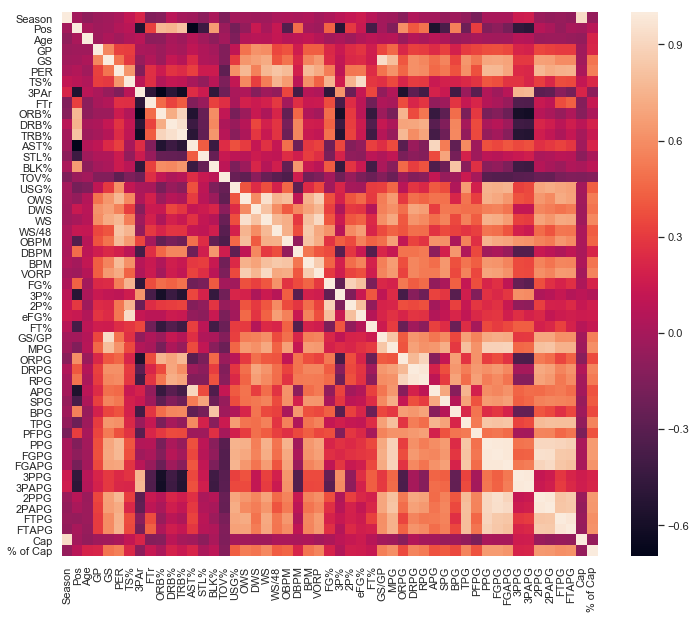

In [611]:
#remove salary in heatmap, store in separate variable
salary=stats['Salary']
stats=stats.drop('Salary', axis=1)


#setting up heatmap for correlations between all statistics
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,10))
corr = stats.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, ax=ax)



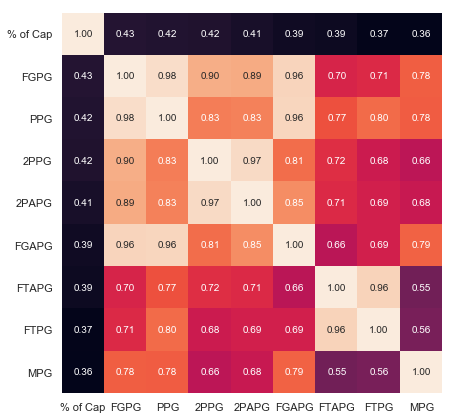

In [612]:
#function that creates heatmaps for the 8 variables that are most strongly correlated with % of Cap for each of the data subsets
def heatMap(df, k):
    corrmat = df.corr(method='pearson', min_periods=1)
    r_square = corrmat ** 2
    ## Top K-1 correlated variables
    cols = r_square.nlargest(k, '% of Cap')['% of Cap'].index
    cm = df[cols].corr()
    cm_square = cm ** 2
    f, ax = plt.subplots(figsize=(7, 7))
    sns.set(font_scale=1.25)
    hm = sns.heatmap(cm_square, cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
    plt.show()
heatMap(stats, 9)

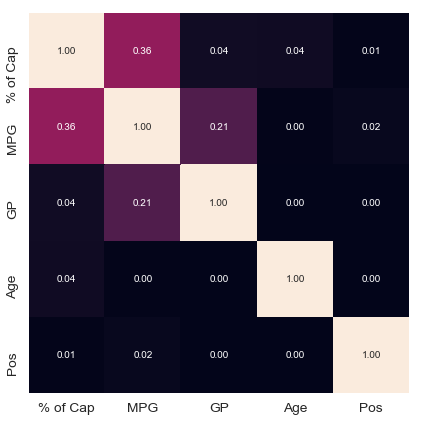

In [613]:
basic_stats=stats[basic]
regular_stats=stats[regular]
advanced_stats=stats[advanced]

#basic only has 5
heatMap(basic_stats, 6)


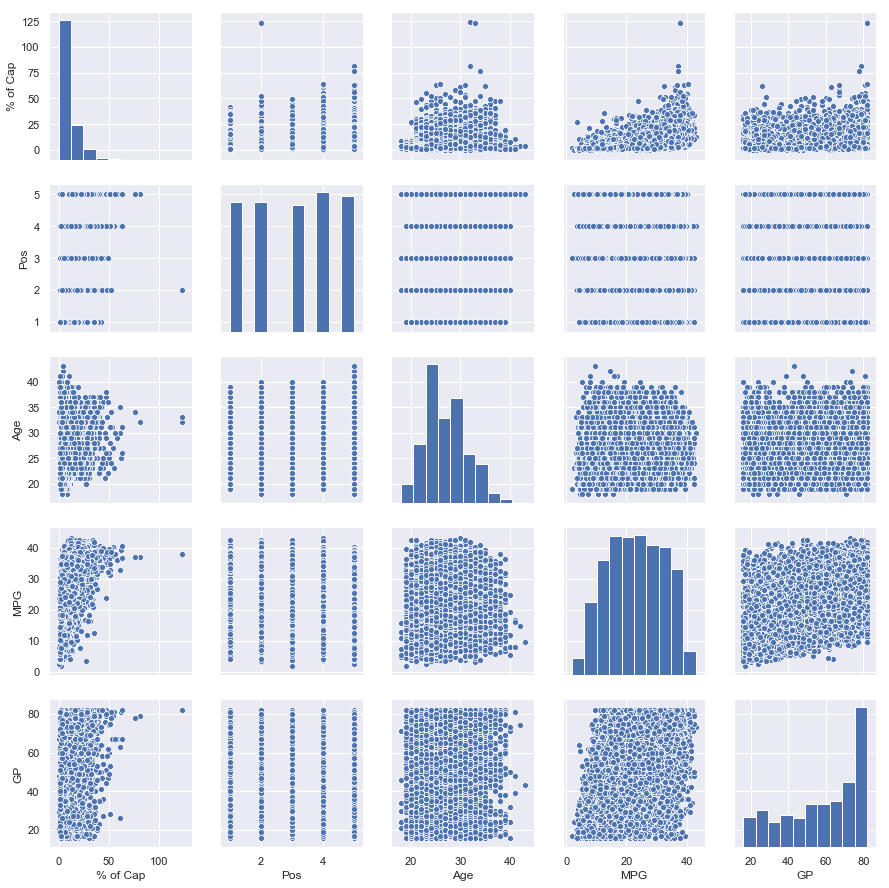

In [614]:
#creating scatter plots to further look at the relationships between % of Cap and other vars
sns.set()
sns.pairplot(basic_stats, height=2.5)
plt.show()

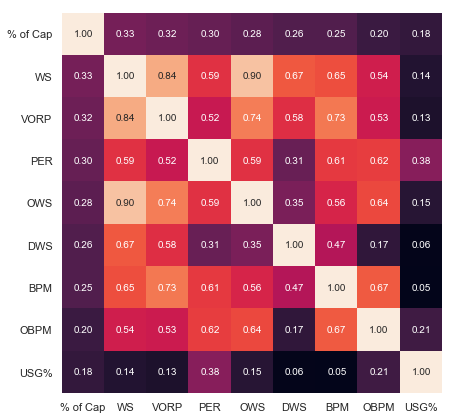

In [615]:
heatMap(advanced_stats, 9)

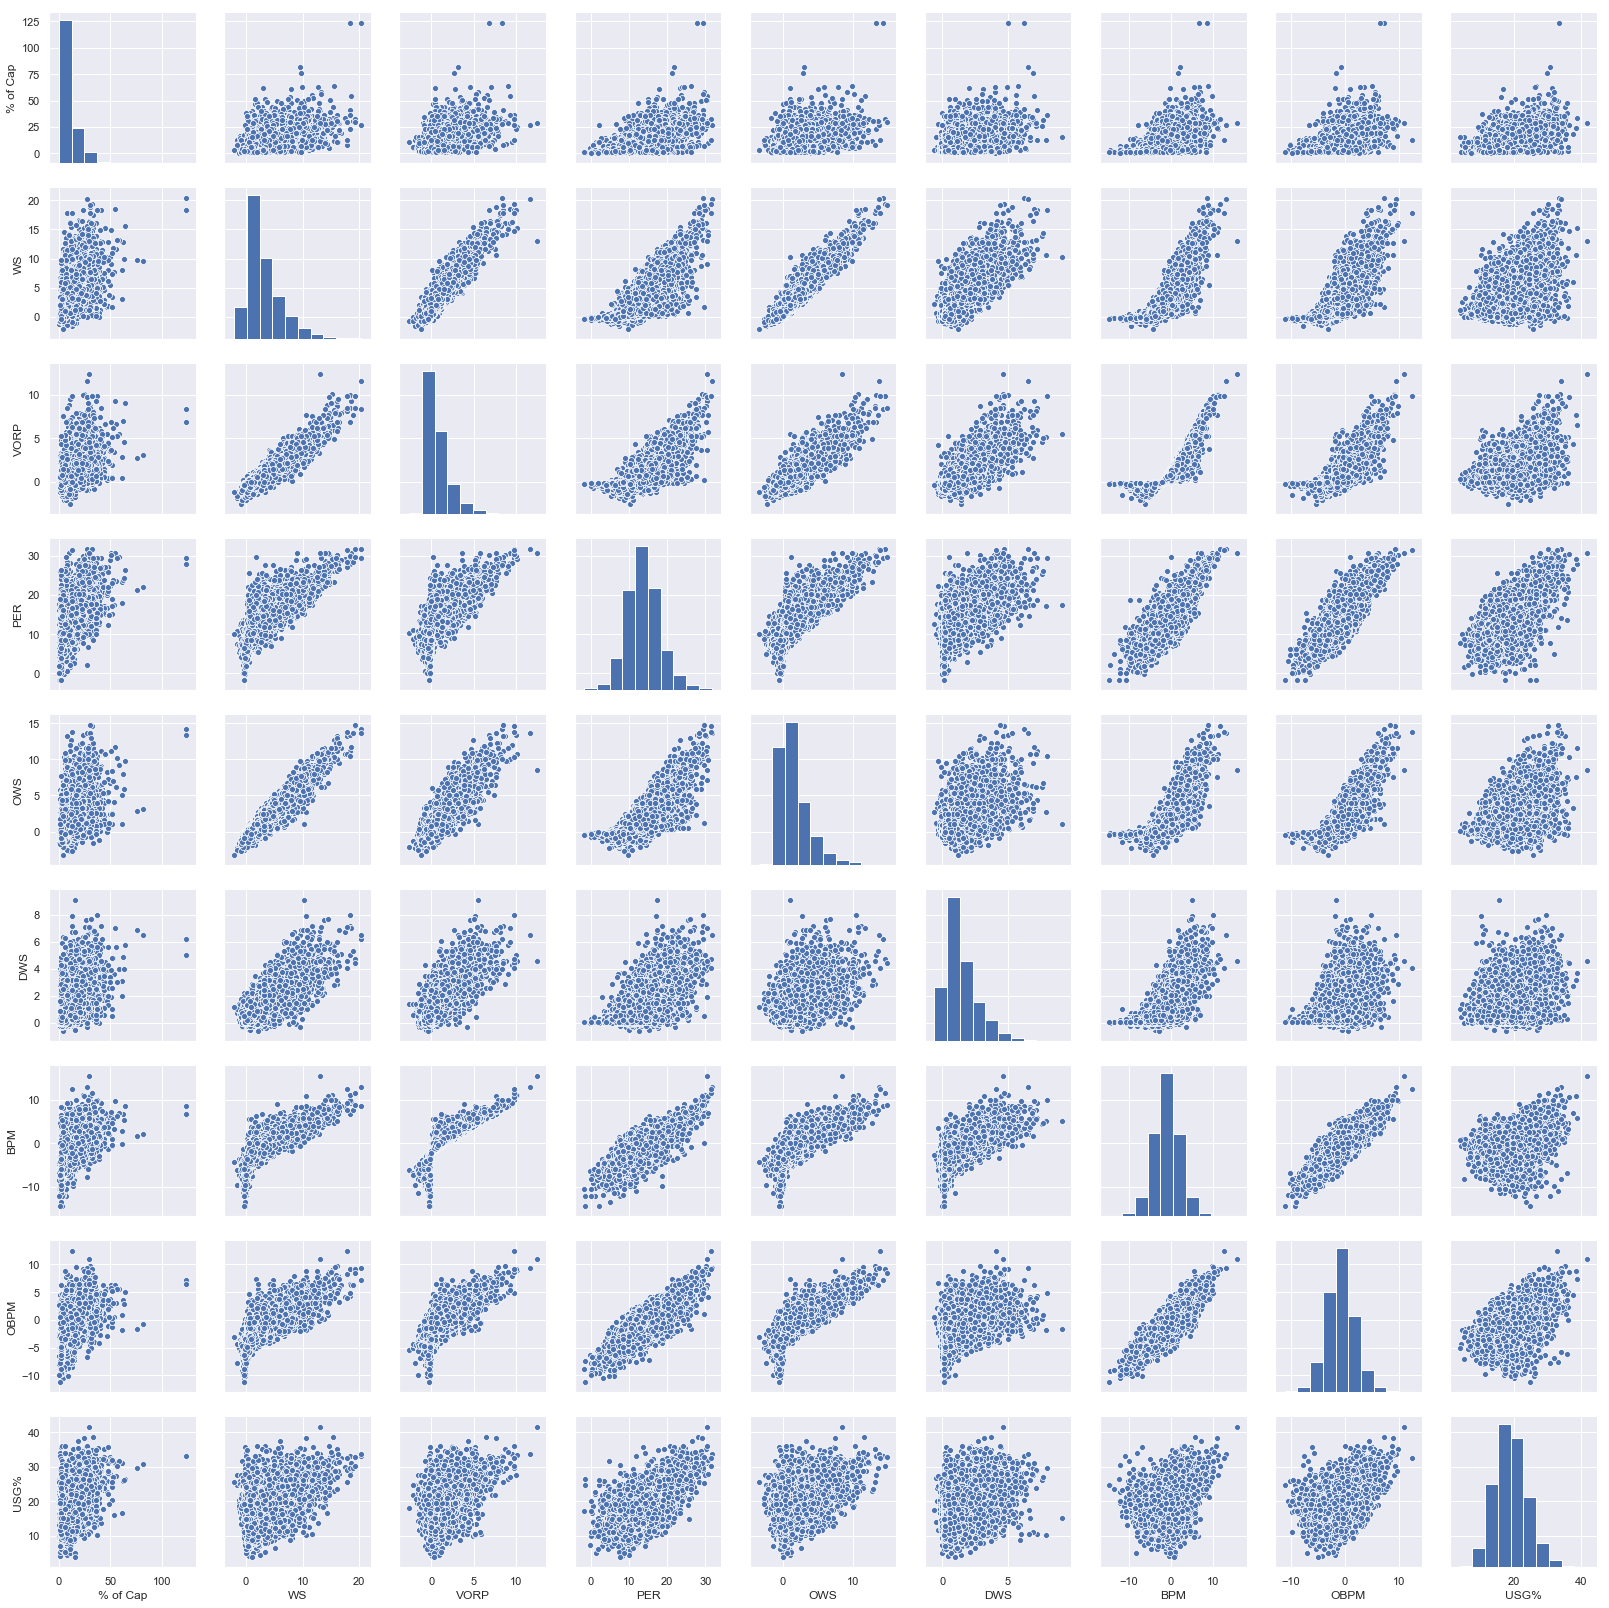

In [616]:
adv=['% of Cap', 'WS', 'VORP','PER','OWS','DWS','BPM','OBPM','USG%',]
sns.set()
sns.pairplot(advanced_stats[adv], height=2.5)
plt.show()

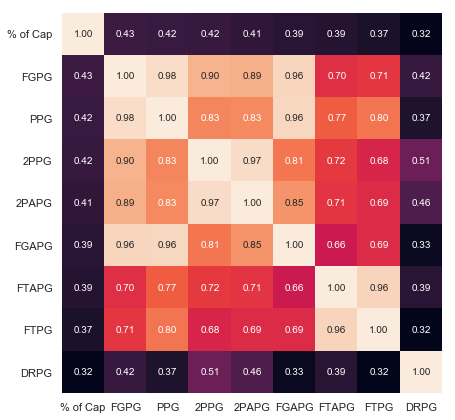

In [617]:
heatMap(regular_stats, 9)

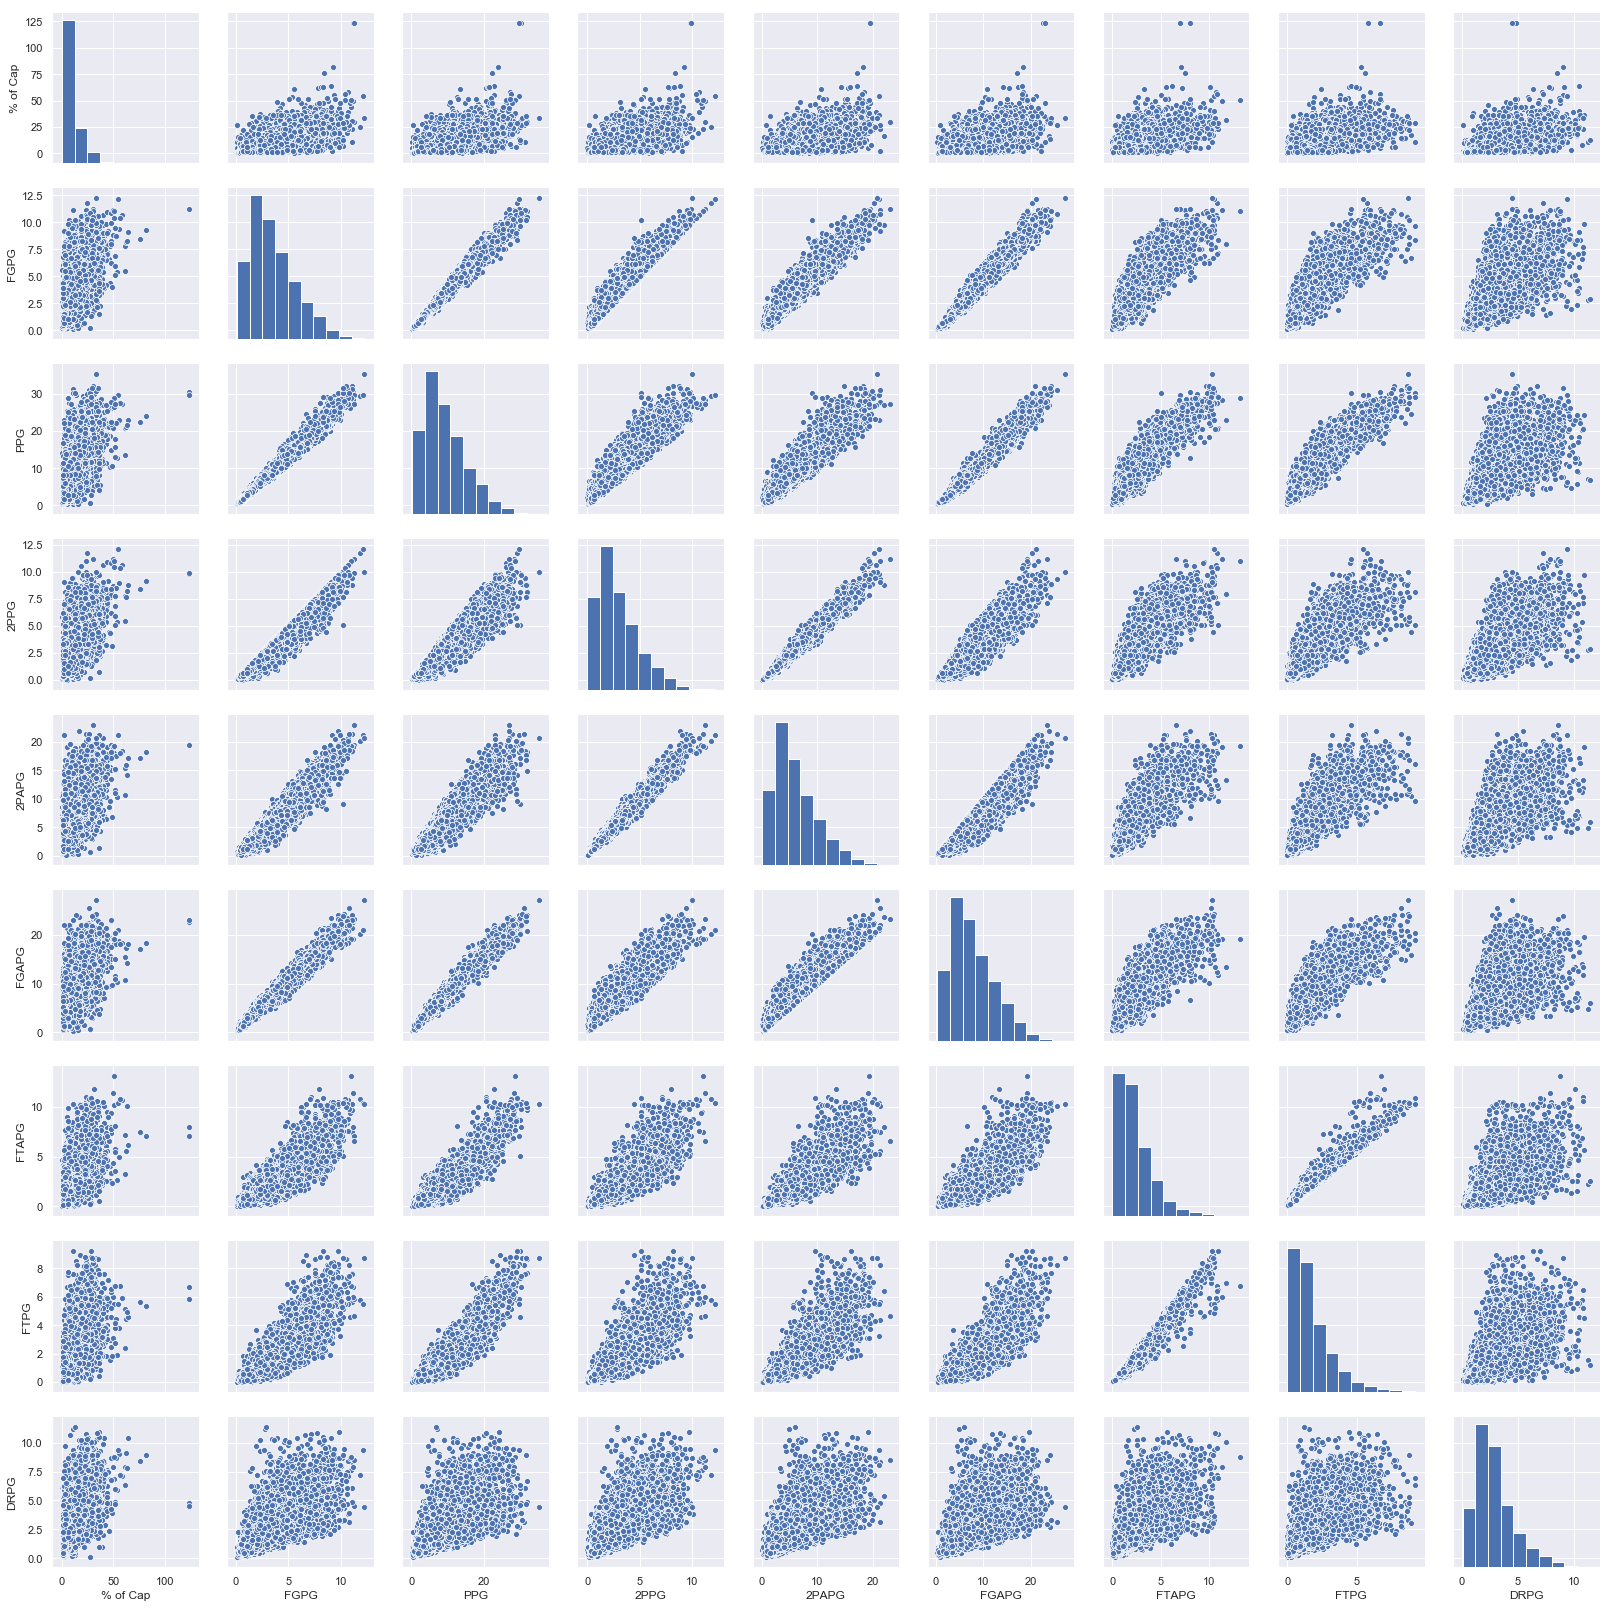

In [618]:
reg=['% of Cap', 'FGPG', 'PPG','2PPG','2PAPG','FGAPG','FTAPG','FTPG','DRPG']
sns.set()
sns.pairplot(regular_stats[reg], height=2.5)
plt.show()

In [619]:
#see if any variables are multicollinear, if so they can be removed
x = advanced_stats[['WS', 'VORP','PER','OWS', 'DWS','BPM','OBPM','USG%']]
basicDF=basic_stats[['Pos', 'Age', 'MPG', 'GP']]
z=regular_stats[['FGPG', 'PPG','2PPG','2PAPG','FGAPG','FTAPG','FTPG','DRPG']]


from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif["features"] = x.columns
vif.round(1)
    
#lower VIF factor values means less multicollinearity

,VIF Factor,features
0,7873.4,WS
1,14.2,VORP
2,53.3,PER
3,3099.3,OWS
4,1495.8,DWS
5,15.8,BPM
6,8.3,OBPM
7,55.0,USG%


In [620]:
#remove OWS and DWS from advanced stats because their VIF factor values are far too high
advancedDF = advanced_stats[['WS', 'VORP','PER','BPM','OBPM','USG%']]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(advancedDF.values, i) for i in range(advancedDF.shape[1])]
vif["features"] = advancedDF.columns
vif.round(1)

,VIF Factor,features
0,16.9,WS
1,13.2,VORP
2,46.7,PER
3,10.1,BPM
4,3.8,OBPM
5,44.6,USG%


In [621]:

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(basicDF.values, i) for i in range(basicDF.shape[1])]
vif["features"] = basicDF.columns
vif.round(1)

#nothing too bad with basic stats

,VIF Factor,features
0,5.2,Pos
1,12.6,Age
2,9.2,MPG
3,10.8,GP


In [622]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(z.values, i) for i in range(z.shape[1])]
vif["features"] = z.columns
vif.round(1)

#some extremely high numbers, let's get rid of a few variables to see if it improves

/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,inf,FGPG
1,inf,PPG
2,inf,2PPG
3,958.500000,2PAPG
4,1067.000000,FGAPG
5,93.400000,FTAPG
6,inf,FTPG
7,7.300000,DRPG


In [623]:
#remove: 2ppg because it's very similar to ppg. fgpg is correlated with fgapg as well. 
#FTPG correlated with FTAPG and FGPG correlated with PPG, so removed  those as well
regularDF=regular_stats[[ 'PPG','2PAPG','FTAPG','DRPG']]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(regularDF.values, i) for i in range(regularDF.shape[1])]
vif["features"] = regularDF.columns
vif.round(1)

,VIF Factor,features
0,26.2,PPG
1,24.7,2PAPG
2,12.0,FTAPG
3,5.9,DRPG


Root Mean Squared Error is : 6.8384064412047065
R sq is : 0.4007731124412325


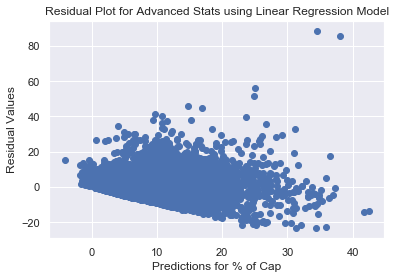

In [624]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import numpy as np

from sklearn.linear_model import LinearRegression

#target array
y=stats[['% of Cap']]


#ADVANCED STATS
linreg = LinearRegression()

#Linear regression on all three subsets of data to see which scores the best
x_train, x_test, y_train, y_test=train_test_split(advancedDF, y, test_size=0.2, random_state=123)
linreg.fit(x_train, y_train)
predictions=linreg.predict(x_test)

#cross validate model
predict = cross_val_predict(linreg, advancedDF, y, cv=6)

#get RMSE and R^2 values
rmse = np.sqrt(mean_squared_error(predict, y))
score = metrics.r2_score(y, predict)
print ('Root Mean Squared Error is :', rmse)
print ('R sq is :', score)

#create residual plot
residuals = y - predict
plt.scatter(predict, residuals)
plt.xlabel('Predictions for % of Cap')
plt.ylabel('Residual Values')
plt.title('Residual Plot for Advanced Stats using Linear Regression Model')
plt.show()

Root Mean Squared Error is : 6.734939701268681
R sq is : 0.41876882977312946


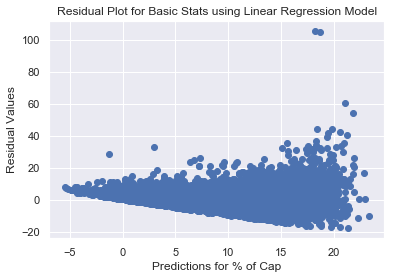

In [625]:
#BASIC STATS
x_train, x_test, y_train, y_test=train_test_split(basicDF, y, test_size=0.2, random_state=123)
linreg.fit(x_train, y_train)
predictions=linreg.predict(x_test)

#cross validate model
predict = cross_val_predict(linreg, basicDF, y, cv=6)

#get RMSE and R^2 values
rmse = np.sqrt(mean_squared_error(predict, y))
score = metrics.r2_score(y, predict)
print ('Root Mean Squared Error is :', rmse)
print ('R sq is :', score)

#create residual plot
residuals = y - predict
plt.scatter(predict, residuals)
plt.xlabel('Predictions for % of Cap')
plt.ylabel('Residual Values')
plt.title('Residual Plot for Basic Stats using Linear Regression Model')
plt.show()

Root Mean Squared Error is : 6.457833389603527
R sq is : 0.4656139096368649


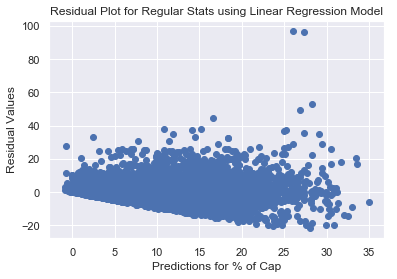

In [626]:
#REGULAR STATS
x_train, x_test, y_train, y_test=train_test_split(regularDF, y, test_size=0.2, random_state=123)
linreg.fit(x_train, y_train)
predictions=linreg.predict(x_test)

#cross validate model
predict = cross_val_predict(linreg, regularDF, y, cv=6)

#get RMSE and R^2 values
rmse = np.sqrt(mean_squared_error(predict, y))
score = metrics.r2_score(y, predict)
print ('Root Mean Squared Error is :', rmse)
print ('R sq is :', score)

#create residual plot
residuals = y - predict
plt.scatter(predict, residuals)
plt.xlabel('Predictions for % of Cap')
plt.ylabel('Residual Values')
plt.title('Residual Plot for Regular Stats using Linear Regression Model')
plt.show()


In [627]:
#Regular Stats had the highest R squared and lowest RMSE values, so that's the subsection that I will be using to look at overvalued and undervalued players
#positive residual=overvalued, negative=undervalued
stats['Predicted % of Cap']=predict
stats['Residuals']=residuals
stats['Resid %']=(stats['Residuals']/stats['% of Cap']*100)

In [628]:
copy=stats
copy=copy[['Season', 'Name', 'Age', 'Team', 'PER', '% of Cap', 'Predicted % of Cap', 'Residuals']]
copy=copy.sort_values('Residuals')
#get top25 most undervalued players
top25=copy[:25]
top25


,Season,Name,Age,Team,PER,% of Cap,Predicted % of Cap,Residuals
12551,2017.0,Karl-Anthony Towns,21.0,MIN,26.0,6.273743,28.032464,-21.758721
4406,2003.0,Karl Malone,39.0,UTA,21.7,3.421533,23.660177,-20.238644
3517,2001.0,Paul Pierce,23.0,BOS,22.3,4.826520,24.796634,-19.970114
6122,2006.0,LeBron James,21.0,CLE,28.1,10.968458,30.816153,-19.847695
5217,2004.0,Zach Randolph,22.0,POR,19.6,3.428931,23.118497,-19.689566
8999,2011.0,Kevin Love,22.0,MIN,24.3,7.941736,27.605995,-19.664259
8385,2010.0,Kevin Durant,21.0,OKC,26.2,10.429438,29.877678,-19.448240
3987,2002.0,Michael Jordan,38.0,WAS,20.7,2.557672,21.658672,-19.101000
3278,2001.0,Dirk Nowitzki,22.0,DAL,22.8,5.076694,24.163166,-19.086472
8704,2011.0,Blake Griffin,21.0,LAC,21.9,9.873682,28.322918,-18.449236


In [629]:
ageMean=top25['Age'].mean()
print ('Average age is:',ageMean)

perMean=top25['PER'].mean()
print ('Average PER is:',perMean)

percentMean=top25['% of Cap'].mean()
print ('Average % of Cap is:',percentMean)

residMean=top25['Residuals'].mean()
print ('Average absolute value Residual is:',-1*residMean, '%')


Average age is: 23.44
Average PER is: 22.864
Average % of Cap is: 5.923764141052273
Average absolute value Residual is: 18.09355209985478 %


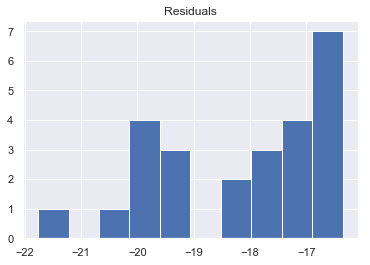

In [630]:
hist=top25.hist(column='Residuals')

In [631]:
#get most overvalued players by residuals
bottom25=copy[-25:]
bottom25

,Season,Name,Age,Team,PER,% of Cap,Predicted % of Cap,Residuals
3416,2001.0,Kevin Garnett,24.0,MIN,23.9,52.705882,25.469724,27.236158
2410,1999.0,Kevin Garnett,22.0,MIN,22.4,49.430294,22.029292,27.401002
11097,2015.0,Cameron Bairstow,24.0,CHI,2.1,27.142857,-0.766960,27.909817
861,1996.0,Reggie Miller,30.0,IND,20.1,46.176579,17.182439,28.994140
4080,2002.0,Shaquille O'Neal,29.0,LAL,29.7,58.532018,29.433868,29.098150
2905,2000.0,Kevin Garnett,23.0,MIN,23.6,55.239437,26.029043,29.210394
5237,2005.0,Allan Houston,33.0,NYK,12.5,38.636364,7.744180,30.892183
3571,2001.0,Scottie Pippen,35.0,POR,15.3,42.549562,11.471871,31.077692
3923,2002.0,Juwan Howard,28.0,DEN,17.1,51.215515,18.375407,32.840108
3667,2002.0,Alonzo Mourning,31.0,MIA,18.9,51.227434,18.344593,32.882841


In [632]:
ageMean=bottom25['Age'].mean()
print ('Average age is:',ageMean)

perMean=bottom25['PER'].mean()
print ('Average PER is:',perMean)

percentMean=bottom25['% of Cap'].mean()
print ('Average % of Cap is:',percentMean)

residMean=bottom25['Residuals'].mean()
print ('Average Residual is:',residMean, '%')



Average age is: 29.8
Average PER is: 19.52
Average % of Cap is: 58.93373251563292
Average Residual is: 39.891697390939925 %


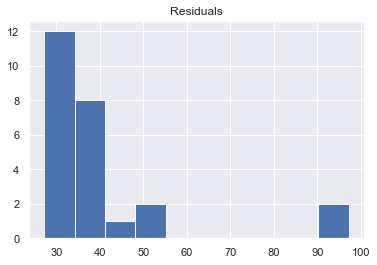

In [633]:
graph=bottom25.hist(column='Residuals')

In [634]:
#trying a different method, because raw residual values tends to discriminate against superstars who are being paid a lot of money

copy2=stats
copy2=copy2[['Season', 'Name', 'Age', 'Team', 'PER','% of Cap', 'Predicted % of Cap', 'Resid %']]
copy2=copy2.sort_values('Resid %')
top25B=copy2[:25]
top25B

,Season,Name,Age,Team,PER,% of Cap,Predicted % of Cap,Resid %
12094,2016.0,P.J. Hairston,23.0,MEM,5.7,0.012252,6.177720,-50323.884455
12093,2016.0,P.J. Hairston,23.0,CHO,7.4,0.012252,5.506244,-44843.149255
6092,2006.0,Kareem Rush,25.0,CHO,9.8,0.036635,7.607046,-20664.428606
11166,2015.0,Dorell Wright,29.0,POR,13.4,0.025196,4.348653,-17159.495517
12286,2017.0,Beno Udrih,34.0,DET,16.1,0.025229,4.350643,-17144.732547
4378,2003.0,Jelani McCoy,25.0,TOR,12.4,0.083583,8.594131,-10182.091748
11839,2016.0,Gary Neal,31.0,WAS,13.5,0.076684,7.541369,-9734.293295
11819,2016.0,Elijah Millsap,28.0,UTA,6.5,0.024504,2.085527,-8410.891657
2418,1999.0,Kornel David,27.0,CHI,13.6,0.079585,5.921091,-7339.931134
7653,2009.0,Desmond Mason,31.0,OKC,7.1,0.133189,8.534463,-6307.787909


In [635]:
ageMean=top25B['Age'].mean()
print ('Average age is:',ageMean)

perMean=top25B['PER'].mean()
print ('Average PER is:',perMean)

percentMean=top25B['% of Cap'].mean()
print ('Average % of Cap is:',percentMean)

residMean=top25B['Resid %'].mean()
print ('Average absolute value Residual is:',-1*residMean, '%')



Average age is: 26.84
Average PER is: 11.252
Average % of Cap is: 0.08920771146442923
Average absolute value Residual is: 10627.093741857827 %


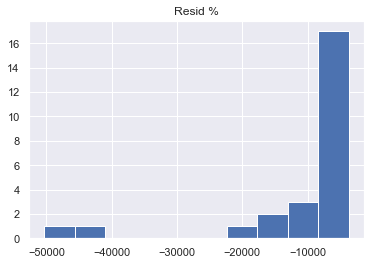

In [636]:
his=top25B.hist(column='Resid %')

In [637]:
bottom25B=copy2[-25:]
bottom25B

,Season,Name,Age,Team,PER,% of Cap,Predicted % of Cap,Resid %
8545,2010.0,Royal Ivey,28.0,MIL,6.8,2.067397,-0.130412,106.308019
6364,2006.0,Yaroslav Korolev,18.0,LAC,4.8,3.448349,-0.238097,106.904656
587,1996.0,David Wood,31.0,GSW,8.7,1.015885,-0.071004,106.989412
5024,2004.0,Michael Stewart,28.0,BOS,1.5,10.941418,-0.771815,107.054065
7935,2009.0,Randolph Morris,23.0,ATL,1.8,1.482130,-0.108253,107.303873
1071,1997.0,Carl Thomas,27.0,CLE,8.5,1.012082,-0.082122,108.114171
4210,2003.0,Brandon Armstrong,22.0,BRK,3.9,2.271099,-0.184880,108.140540
5695,2005.0,Robert Swift,19.0,OKC,5.2,3.564606,-0.374215,110.498064
4324,2003.0,Fred Jones,23.0,IND,5.5,3.435219,-0.370181,110.776066
6511,2007.0,Didier Ilunga-Mbenga,26.0,DAL,7.2,3.235664,-0.387525,111.976686


In [638]:
ageMean=bottom25B['Age'].mean()
print ('Average age is:',ageMean)

perMean=bottom25B['PER'].mean()
print ('Average PER is:',perMean)

percentMean=bottom25B['% of Cap'].mean()
print ('Average % of Cap is:',percentMean)

residMean=bottom25B['Resid %'].mean()
print ('Average absolute value Residual is:',-1*residMean, '%')



Average age is: 26.44
Average PER is: 4.884
Average % of Cap is: 2.126894667752174
Average absolute value Residual is: -309.00708706292767 %


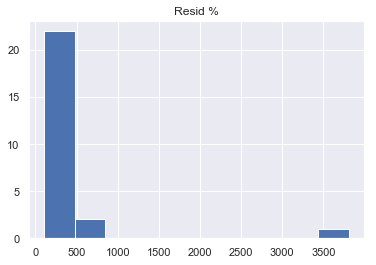

In [639]:
hisB=bottom25B.hist(column='Resid %')

In [646]:
#Resid % (copy2) is a better indicator of who is overvalued and undervalued

#now grouping by team to determine which teams best value their players, and if there's an effect on how much they win?
teams=copy.groupby('Team').mean()
teams['Resid %']=(teams['Residuals']/teams['% of Cap']) *100
teams=teams.drop("Season", axis=1)


In [647]:
#adding in wins per team over 1995-2017
x=pd.read_csv('nbaTeamWins.csv')
wins=x[['Team', 'Average Wins']]
wins.set_index('Team')
lis=wins['Average Wins'].tolist()
teams['Avg Wins']=lis
teams

,Age,PER,% of Cap,Predicted % of Cap,Residuals,Resid %,Avg Wins
Team,,,,,,,
ATL,26.753676,13.634559,8.691794,9.040563,-0.348769,-4.012618,38.217391
BOS,26.334586,13.404887,8.808181,8.801429,0.006753,0.076664,40.869565
BRK,27.003745,13.218352,9.258158,9.134652,0.123506,1.334025,33.826087
CHI,27.022472,13.411610,9.469930,9.077095,0.392835,4.148237,40.826087
CHO,26.505263,12.938947,6.883444,8.366333,-1.482889,-21.542836,31.857143
CLE,26.393502,13.250181,8.866430,9.154724,-0.288294,-3.251523,40.130435
DAL,27.907749,14.198893,9.711257,8.814293,0.896964,9.236333,44.521739
DEN,26.533333,13.967451,8.251178,9.347896,-1.096718,-13.291660,37.739130
DET,27.228137,13.817871,8.482736,8.557897,-0.075161,-0.886048,41.521739


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


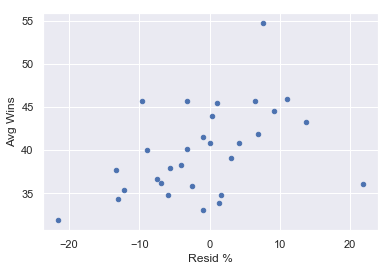

In [643]:
scat=teams.plot.scatter('Resid %', 'Avg Wins')